In [ ]:
device = "cuda"

In [ ]:
import os
import cv2
import math
import torch
import shutil 
import random
import numpy as np 
import pandas as pd 
from PIL import Image
import torch.nn as nn
from torch import cuda
from torch.optim import Adam
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from skimage.color import rgb2lab, lab2rgb
import torchvision.models as models
from tqdm import tqdm

In [ ]:
from google.colab import drive
import shutil
def save_model(model):
  drive.mount('/content/drive')
  shutil.copy("/content/" + model, "/content/drive/MyDrive/cv thesis/model")
  print("Model Saved")
  drive.flush_and_unmount()

In [ ]:
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1TM_yqc2X807QcQv6Wq7R18wSICGoSRwH #importing dataset.py

In [ ]:
!gdown --id 1Csq7o2JqQjUkmPM4JPFwPIA74-_ik5Mt #Sample 12k imagenet
!gdown --id 1smp7oD7RftKQCyQrlL7Jf3T0OGg8UURl #Caption file - sampled.csv

In [ ]:
!gdown --id 1-zdr4QV1_-OQxQ-URN2zb1JNojHm3pyO #resnet - gray
!gdown --id 1-jFyCtViLuwmRlfepHKKIdgFjvDvPlTS #epoch trained weight

In [ ]:
!gdown --id 1YHdTCB4eMCbn4TAPtrdgIJLYF5cC9rt4 #Kota dataset
!unzip kota.zip

In [ ]:
!ls

In [ ]:
!unzip images.zip

In [ ]:
from dataset import *

In [ ]:
color_transform = transforms.Compose([
            transforms.Resize((300, 300), Image.BICUBIC),
            transforms.CenterCrop(256),
        ])
transform = transforms.Compose([
            transforms.ToTensor()
        ])

dataset = ImageDataset(r"/content/images", r"/content/sampled.csv", color_transform, transform)
loader = DataLoader(dataset=dataset, batch_size = 32, num_workers = 0, shuffle = False, pin_memory = True, drop_last = False)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
for batch in loader:
  print(batch[0].shape)
  break

torch.Size([32, 1, 256, 256])


In [ ]:
class ColorizationNet(nn.Module):
    def __init__(self, midlevel_input_size=128, global_input_size=512):
        super(ColorizationNet, self).__init__()
        # Fusion layer to combine midlevel and global features

        self.midlevel_input_size = midlevel_input_size
        self.global_input_size = global_input_size

        self.fusion = nn.Linear(midlevel_input_size + global_input_size, midlevel_input_size)
        self.bn1 = nn.BatchNorm1d(midlevel_input_size)

        # Convolutional layers and upsampling
        self.deconv1_new = nn.ConvTranspose2d(midlevel_input_size, 128, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.Conv2d(midlevel_input_size, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)
        self.upsample = nn.Upsample(scale_factor=2)
        print('Loaded colorization net.')

    def forward(self, midlevel_input , global_input):
        # Convolutional layers and upsampling
        x = F.relu(self.bn2(self.conv1(midlevel_input)))
        x = self.upsample(x)
        x = F.relu(self.bn3(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.upsample(x)
        x = F.sigmoid(self.conv4(x))
        x = self.upsample(self.conv5(x))
        return x

In [ ]:
class ColorNet(nn.Module):
    def __init__(self):
        super(ColorNet, self).__init__()
        
        # Build ResNet and change first conv layer to accept single-channel input
        resnet_gray_model = models.resnet18(num_classes=365)
        resnet_gray_model.conv1.weight = nn.Parameter(resnet_gray_model.conv1.weight.sum(dim=1).unsqueeze(1).data)
        
        # Only needed if not resuming from a checkpoint: load pretrained ResNet-gray model
        if torch.cuda.is_available(): # and only if gpu is available
            resnet_gray_weights = torch.load('resnet_gray_weights.pth.tar') #torch.load('pretrained/resnet_gray.tar')['state_dict']
            resnet_gray_model.load_state_dict(resnet_gray_weights)
            print('Pretrained ResNet-gray weights loaded')

        # Extract midlevel and global features from ResNet-gray
        self.midlevel_resnet = nn.Sequential(*list(resnet_gray_model.children())[0:6])
        self.global_resnet = nn.Sequential(*list(resnet_gray_model.children())[0:9])
        self.fusion_and_colorization_net = ColorizationNet()

    def forward(self, input_image):

        # Pass input through ResNet-gray to extract features
        midlevel_output = self.midlevel_resnet(input_image)
        global_output = self.global_resnet(input_image)
        # print("Midlevel :", midlevel_output.shape)
        # print("Global :", global_output.shape)

        # Combine features in fusion layer and upsample
        output = self.fusion_and_colorization_net(midlevel_output , global_output)
        return output

In [ ]:
import torchvision.models as models
class VGG19(torch.nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()
        features = models.vgg19(pretrained=True).features
        self.relu1_1 = torch.nn.Sequential()
        self.relu1_2 = torch.nn.Sequential()

        self.relu2_1 = torch.nn.Sequential()
        self.relu2_2 = torch.nn.Sequential()

        self.relu3_1 = torch.nn.Sequential()
        self.relu3_2 = torch.nn.Sequential()
        self.relu3_3 = torch.nn.Sequential()
        self.relu3_4 = torch.nn.Sequential()

        self.relu4_1 = torch.nn.Sequential()
        self.relu4_2 = torch.nn.Sequential()
        self.relu4_3 = torch.nn.Sequential()
        self.relu4_4 = torch.nn.Sequential()

        self.relu5_1 = torch.nn.Sequential()
        self.relu5_2 = torch.nn.Sequential()
        self.relu5_3 = torch.nn.Sequential()
        self.relu5_4 = torch.nn.Sequential()

        for x in range(2):
            self.relu1_1.add_module(str(x), features[x])

        for x in range(2, 4):
            self.relu1_2.add_module(str(x), features[x])

        for x in range(4, 7):
            self.relu2_1.add_module(str(x), features[x])

        for x in range(7, 9):
            self.relu2_2.add_module(str(x), features[x])

        for x in range(9, 12):
            self.relu3_1.add_module(str(x), features[x])

        for x in range(12, 14):
            self.relu3_2.add_module(str(x), features[x])

        for x in range(14, 16):
            self.relu3_2.add_module(str(x), features[x])

        for x in range(16, 18):
            self.relu3_4.add_module(str(x), features[x])

        for x in range(18, 21):
            self.relu4_1.add_module(str(x), features[x])

        for x in range(21, 23):
            self.relu4_2.add_module(str(x), features[x])

        for x in range(23, 25):
            self.relu4_3.add_module(str(x), features[x])

        for x in range(25, 27):
            self.relu4_4.add_module(str(x), features[x])

        for x in range(27, 30):
            self.relu5_1.add_module(str(x), features[x])

        for x in range(30, 32):
            self.relu5_2.add_module(str(x), features[x])

        for x in range(32, 34):
            self.relu5_3.add_module(str(x), features[x])

        for x in range(34, 36):
            self.relu5_4.add_module(str(x), features[x])

        # don't need the gradients, just want the features
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        relu1_1 = self.relu1_1(x)
        relu1_2 = self.relu1_2(relu1_1)

        relu2_1 = self.relu2_1(relu1_2)
        relu2_2 = self.relu2_2(relu2_1)

        relu3_1 = self.relu3_1(relu2_2)
        relu3_2 = self.relu3_2(relu3_1)
        relu3_3 = self.relu3_3(relu3_2)
        relu3_4 = self.relu3_4(relu3_3)

        relu4_1 = self.relu4_1(relu3_4)
        relu4_2 = self.relu4_2(relu4_1)
        relu4_3 = self.relu4_3(relu4_2)
        relu4_4 = self.relu4_4(relu4_3)

        relu5_1 = self.relu5_1(relu4_4)
        relu5_2 = self.relu5_2(relu5_1)
        relu5_3 = self.relu5_3(relu5_2)
        relu5_4 = self.relu5_4(relu5_3)

        out = {
            'relu1_1': relu1_1,
            'relu1_2': relu1_2,

            'relu2_1': relu2_1,
            'relu2_2': relu2_2,

            'relu3_1': relu3_1,
            'relu3_2': relu3_2,
            'relu3_3': relu3_3,
            'relu3_4': relu3_4,

            'relu4_1': relu4_1,
            'relu4_2': relu4_2,
            'relu4_3': relu4_3,
            'relu4_4': relu4_4,

            'relu5_1': relu5_1,
            'relu5_2': relu5_2,
            'relu5_3': relu5_3,
            'relu5_4': relu5_4,
        }
        return out

In [ ]:
class PerceptualLoss(nn.Module):
    """
    Perceptual loss, VGG-based
    https://arxiv.org/abs/1603.08155
    https://github.com/dxyang/StyleTransfer/blob/master/utils.py
    """

    def __init__(self, weights = [ 1.0, 1.0, 1.0, 1.0, 1.0] ):
        super(PerceptualLoss, self).__init__()
        self.add_module('vgg', VGG19().to("cuda"))
        self.criterion = torch.nn.L1Loss()
        self.weights = weights

    def __call__(self, x, y):
        # Compute features
        x_vgg, y_vgg = self.vgg(x), self.vgg(y)

        content_loss = 0.0
        content_loss += self.weights[0] * self.criterion(x_vgg['relu1_1'], y_vgg['relu1_1'])
        content_loss += self.weights[1] * self.criterion(x_vgg['relu2_1'], y_vgg['relu2_1'])
        content_loss += self.weights[2] * self.criterion(x_vgg['relu3_1'], y_vgg['relu3_1'])
        content_loss += self.weights[3] * self.criterion(x_vgg['relu4_1'], y_vgg['relu4_1'])
        content_loss += self.weights[4] * self.criterion(x_vgg['relu5_1'], y_vgg['relu5_1'])


        return content_loss

In [ ]:
net_G = ColorNet().to(device)

Pretrained ResNet-gray weights loaded
Loaded colorization net.


In [ ]:
if os.path.exists("/content/checkpoint-trained.pth.tar"):
  checkpoint = torch.load('/content/checkpoint-trained.pth.tar')
  net_G.load_state_dict(checkpoint['state_dict'])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
net_G = ColorNet().to(device)
net_G.load_state_dict(torch.load('/content/netG_pretrained_fine_tune_5.pt'))

Pretrained ResNet-gray weights loaded
Loaded colorization net.


<All keys matched successfully>

In [ ]:
opt = Adam(net_G.parameters(), lr = 1e-4)
criterion_perceptual = PerceptualLoss()
criterion_l1 = torch.nn.L1Loss()
epochs = 1

In [ ]:
net_G.train()
for e in range(6, 11):
  loss_average = 0.0
  for batch in tqdm(loader):
    L, ab = batch[0].to(device, dtype = torch.float32), batch[1].to(device, dtype = torch.float32)
    pred = net_G(L)

    original =  torch.cat([L, ab], dim = 1)
    fake = torch.cat([L, pred], dim = 1)

    loss_l1 = criterion_l1(fake, original)
    loss_perceptual = criterion_perceptual(fake, original)
    opt.zero_grad()
    loss = 2*loss_l1 + 1*loss_perceptual
    loss.backward()
    opt.step()
    loss_average += loss_l1.item() + loss_perceptual.item()

  print(f"Epoch {e + 1}/{epochs}")
  print(f"Loss: {loss_average/len(loader):.5f}")
  path = "netG_pretrained_fine_tune_" + str(e) + ".pt"
  print("Path :", path)
  torch.save(net_G.state_dict(), "/content/" + path)
  save_model(path)

  0%|          | 0/376 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 376/376 [09:46<00:00,  1.56s/it]


Epoch 7/1
Loss: 0.42859
Path : netG_pretrained_fine_tune_6.pt
Mounted at /content/drive
Model Saved


100%|██████████| 376/376 [09:42<00:00,  1.55s/it]


Epoch 8/1
Loss: 0.42824
Path : netG_pretrained_fine_tune_7.pt
Mounted at /content/drive
Model Saved


100%|██████████| 376/376 [09:39<00:00,  1.54s/it]


Epoch 9/1
Loss: 0.42798
Path : netG_pretrained_fine_tune_8.pt
Mounted at /content/drive
Model Saved


100%|██████████| 376/376 [09:38<00:00,  1.54s/it]


Epoch 10/1
Loss: 0.42772
Path : netG_pretrained_fine_tune_9.pt
Mounted at /content/drive
Model Saved


100%|██████████| 376/376 [09:39<00:00,  1.54s/it]


Epoch 11/1
Loss: 0.42747
Path : netG_pretrained_fine_tune_10.pt
Mounted at /content/drive
Model Saved


In [ ]:
net_G.train()
for e in range(2):
  loss_average = 0.0
  for batch in tqdm(loader):
    L, ab = batch[0].to(device, dtype = torch.float32), batch[1].to(device, dtype = torch.float32)
    pred = net_G(L)

    original =  torch.cat([L, ab], dim = 1)
    fake = torch.cat([L, pred], dim = 1)

    loss_l1 = criterion_l1(fake, original)
    loss_perceptual = criterion_perceptual(fake, original)
    opt.zero_grad()
    loss = loss_l1 + loss_perceptual
    loss.backward()
    opt.step()
    loss_average += loss_l1.item() + loss_perceptual.item()

  print(f"Epoch {e + 1}/{epochs}")
  print(f"Loss: {loss_average/len(loader):.5f}")
  torch.save(net_G.state_dict(), "bbaba.pt")
  # save_model("res34_lab_perceptual_unet.pt")

  0%|          | 0/376 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 376/376 [13:04<00:00,  2.09s/it]


Epoch 1/1
Loss: 0.43941


100%|██████████| 376/376 [13:04<00:00,  2.09s/it]

Epoch 2/1
Loss: 0.43820


In [ ]:
net_G.train()
for e in range(2):
  loss_average = 0.0
  for batch in tqdm(loader):
    L, ab = batch[0].to(device, dtype = torch.float32), batch[1].to(device, dtype = torch.float32)
    pred = net_G(L)

    original =  torch.cat([L, ab], dim = 1)
    fake = torch.cat([L, pred], dim = 1)

    loss_l1 = criterion_l1(fake, original)
    loss_perceptual = criterion_perceptual(fake, original)
    opt.zero_grad()
    loss = loss_l1 + loss_perceptual
    loss.backward()
    opt.step()
    loss_average += loss_l1.item() + loss_perceptual.item()

  print(f"Epoch {e + 1}/{epochs}")
  print(f"Loss: {loss_average/len(loader):.5f}")
  torch.save(net_G.state_dict(), "bbaba.pt")
  # save_model("res34_lab_perceptual_unet.pt")

  0%|          | 0/376 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 376/376 [13:11<00:00,  2.11s/it]


Epoch 1/1
Loss: 0.43745


100%|██████████| 376/376 [13:05<00:00,  2.09s/it]

Epoch 2/1
Loss: 0.43688


In [ ]:
opt = Adam(net_G.parameters(), lr = 1e-3)
criterion_perceptual = PerceptualLoss()
# criterion_l1 = torch.nn.L1Loss()
net_G.train()
for e in range(2):
  loss_average = 0.0
  for batch in tqdm(loader):
    L, ab = batch[0].to(device, dtype = torch.float32), batch[1].to(device, dtype = torch.float32)
    pred = net_G(L)

    original =  torch.cat([L, ab], dim = 1)
    fake = torch.cat([L, pred], dim = 1)

    # loss_l1 = criterion_l1(fake, original)
    loss_perceptual = criterion_perceptual(fake, original)
    opt.zero_grad()
    # loss = loss_perceptual
    loss_perceptual.backward()
    opt.step()
    loss_average +=  loss_perceptual.item()

  print(f"Epoch {e + 1}/{epochs}")
  print(f"Loss: {loss_average/len(loader):.5f}")
  torch.save(net_G.state_dict(), "bbaba.pt")
  # save_model("res34_lab_perceptual_unet.pt")

  0%|          | 0/376 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 376/376 [13:12<00:00,  2.11s/it]


Epoch 1/1
Loss: 0.41855


100%|██████████| 376/376 [13:04<00:00,  2.09s/it]

Epoch 2/1
Loss: 0.41240


  0%|          | 0/376 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([32, 2, 256, 256])


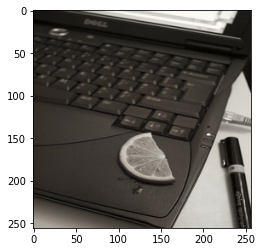

  0%|          | 0/376 [00:01<?, ?it/s]


In [ ]:
net_G.eval()
for batch in tqdm(loader):
  L, ab = batch[0].to(device, dtype = torch.float32), batch[1].to(device, dtype = torch.float32)
  output = net_G(L)
  print(output.shape)
  fake = torch.cat([L, output], dim = 1).detach().cpu().numpy()
  color_image = fake[0]
  color_image = color_image.transpose((1, 2, 0))
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128
  color_image = lab2rgb(color_image.astype(np.float64))
  # L_scaled = (L)*100
  # ab_scaled = (ab * 255) - 128
  # output_scaled = (output * 255) - 128
  # fake = torch.cat([L_scaled, output_scaled], dim = 1)
  # color = torch.cat([L_scaled, ab_scaled], dim = 1)
  plt.imshow(color_image)
  plt.show()
  # plt.imshow(color[4].detach().cpu().permute(1,2,0).numpy())
  # plt.show()
  break

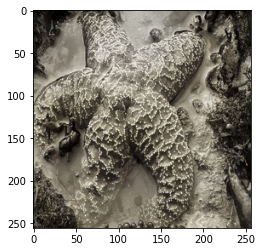

In [ ]:
color_image = fake[10]
color_image = color_image.transpose((1, 2, 0))
color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128
color_image = lab2rgb(color_image.astype(np.float64))
  # L_scaled = (L)*100
  # ab_scaled = (ab * 255) - 128
  # output_scaled = (output * 255) - 128
  # fake = torch.cat([L_scaled, output_scaled], dim = 1)
  # color = torch.cat([L_scaled, ab_scaled], dim = 1)
plt.imshow(color_image)

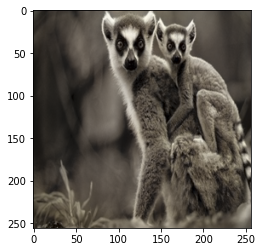

In [ ]:
color_image = fake[25]
color_image = color_image.transpose((1, 2, 0))
color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128
color_image = lab2rgb(color_image.astype(np.float64))
  # L_scaled = (L)*100
  # ab_scaled = (ab * 255) - 128
  # output_scaled = (output * 255) - 128
  # fake = torch.cat([L_scaled, output_scaled], dim = 1)
  # color = torch.cat([L_scaled, ab_scaled], dim = 1)
plt.imshow(color_image)

In [ ]:
!ls

bbaba.pt    images	__pycache__		     sample_data
dataset.py  images.zip	resnet_gray_weights.pth.tar  sampled.csv


In [ ]:
torch.save(net_G.state_dict(), "color_net_lab_image_net_epoch_7.pt")

In [ ]:
save_model("color_net_lab_image_net_epoch_7.pt")

In [ ]:
color_transform1 = transforms.Compose([
            transforms.Resize((600, 800), Image.BICUBIC),

        ])
transform1 = transforms.Compose([
            transforms.ToTensor()
        ])

dataset = ImageDataset(r"/content/Kota", r"/content/kota.csv", color_transform1, transform1)
kota_loader = DataLoader(dataset=dataset, batch_size = 8, num_workers = 0, shuffle = False, pin_memory = True, drop_last = False)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
net_G = ColorNet().to("cpu")
net_G.load_state_dict(torch.load('/content/netG_pretrained_fine_tune_10.pt'))

Pretrained ResNet-gray weights loaded
Loaded colorization net.


<All keys matched successfully>

batch number : 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([8, 2, 600, 800])


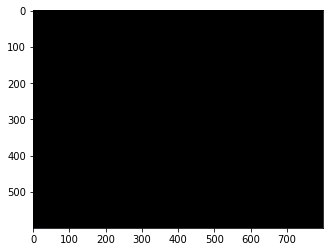

batch number : 3
torch.Size([8, 2, 600, 800])


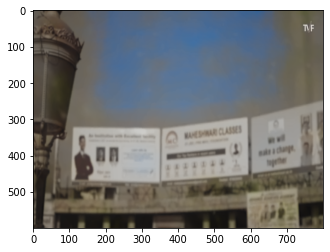

batch number : 6
torch.Size([8, 2, 600, 800])


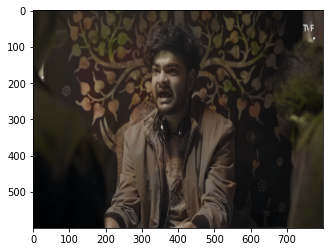

batch number : 9
torch.Size([8, 2, 600, 800])


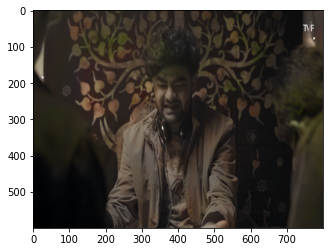

batch number : 12
torch.Size([8, 2, 600, 800])


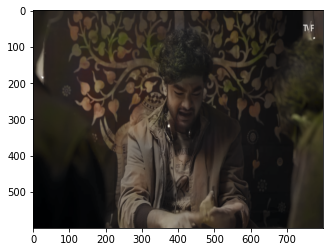

batch number : 15
torch.Size([8, 2, 600, 800])


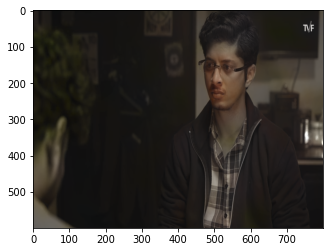

batch number : 18
torch.Size([8, 2, 600, 800])


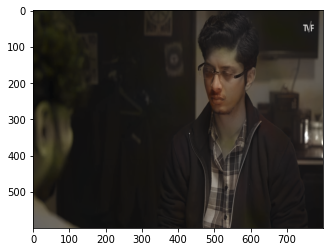

batch number : 21
torch.Size([8, 2, 600, 800])


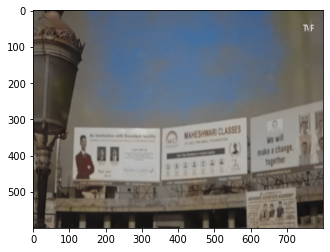

batch number : 24
torch.Size([8, 2, 600, 800])


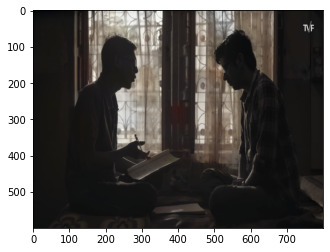

batch number : 27
torch.Size([8, 2, 600, 800])


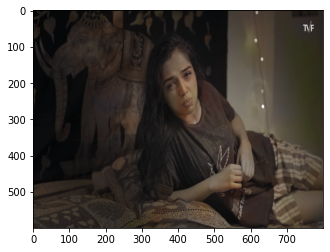

batch number : 30
torch.Size([8, 2, 600, 800])


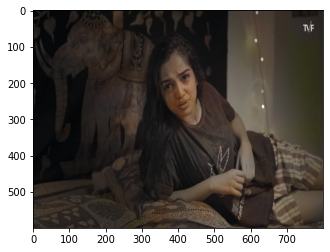

batch number : 33
torch.Size([8, 2, 600, 800])


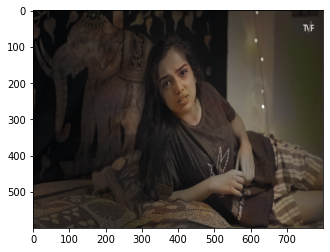

batch number : 36
torch.Size([8, 2, 600, 800])


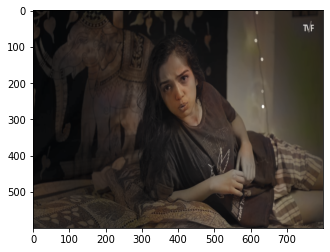

batch number : 39
torch.Size([8, 2, 600, 800])


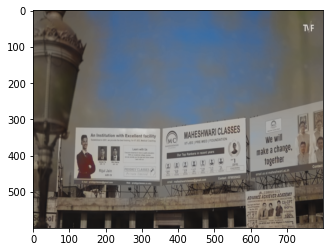

batch number : 42
torch.Size([8, 2, 600, 800])


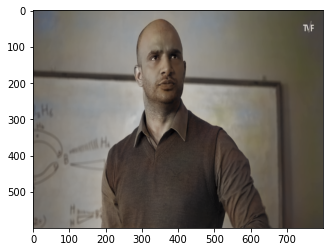

batch number : 45
torch.Size([8, 2, 600, 800])


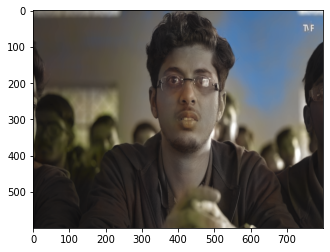

batch number : 48
torch.Size([8, 2, 600, 800])


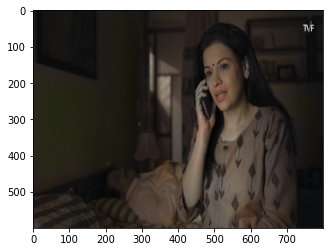

batch number : 51


KeyboardInterrupt: ignored

In [ ]:
net_G.eval()
for idx,  batch in enumerate(kota_loader):
  if idx % 3 != 0:
    continue
  print("batch number :", idx)
  L, ab = batch[0].to("cpu", dtype = torch.float32), batch[1].to("cpu", dtype = torch.float32)
  output = net_G(L)
  print(output.shape)
  fake = torch.cat([L, output], dim = 1).detach().cpu().numpy()
  color_image = fake[0]
  color_image = color_image.transpose((1, 2, 0))
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128
  color_image = lab2rgb(color_image.astype(np.float64))
  # L_scaled = (L)*100
  # ab_scaled = (ab * 255) - 128
  # output_scaled = (output * 255) - 128
  # fake = torch.cat([L_scaled, output_scaled], dim = 1)
  # color = torch.cat([L_scaled, ab_scaled], dim = 1)
  plt.imshow(color_image)
  plt.show()
  # plt.imshow(color[4].detach().cpu().permute(1,2,0).numpy())
  # plt.show()
  

In [ ]:
for e in range(1 , 6):
  print(e)

1
2
3
4
5


In [ ]:
path = "netG_pretrained_fine_tune_" + str(90 + 1) + ".pt"
torch.save(net_G.state_dict(), "/content/" + path)

In [ ]:
!ls

checkpoint-trained.pth.tar	netG_pretrained_fine_tune_3.pt
dataset.py			netG_pretrained_fine_tune_4.pt
images				netG_pretrained_fine_tune_5.pt
images.zip			netG_pretrained_fine_tune_91.pt
Kota				netG_pretrained_fine_tune.pt
kota.csv			__pycache__
kota.zip			resnet_gray_weights.pth.tar
netG_pretrained_fine_tune_1.pt	sample_data
netG_pretrained_fine_tune_2.pt	sampled.csv
